# Adjoint Plugin: 4 Multi-Objective Gradients

In this notebook, we will show how to use the adjoint plugin efficiently for objectives involving several simulations.

One common application of this, which we will explore, is objective functions that depend on several frequencies.

In [1]:
import numpy as np
import jax.numpy as jnp
import jax

import tidy3d as td
import tidy3d.plugins.adjoint as tda

[10:35:46] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=903648;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=374654;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#103\103]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.9.0rc2                                                  ]8;id=981007;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=741255;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#121\121]8;;\

### Setup

First, let's define the frequencies that our objective will depend on

In [2]:
freq_min = 1e14
freq_max = 2e14
num_freqs = 2
freqs = np.linspace(freq_min, freq_max, num_freqs)

wavelength_max = td.C_0 / freq_min

Now we set up some physical parameters.

We will be putting a `td.Box` in the center of a domain with a point source on one side and a diffraction monitor on the other.

The objective will involve summing the power of the 0th order diffraction order over all frequencies defined above.

The gradient of this objective will be computed with respect to the permittivity of the box.

In [3]:
permittivity_val = 2.0

lx = wavelength_max
ly = wavelength_max
lz = wavelength_max

buffer = 2 * wavelength_max

Lx = lx + 2 * buffer
Ly = ly + 2 * buffer
Lz = lz + 2 * buffer

src_pos_x = -Lx/2 + buffer/2
mnt_pos_x = +Lx/2 - buffer/2

In [4]:
def make_sim(permittivity: float, freq: float) -> tda.JaxSimulation:
    """Make a simulation as a function of the box permittivity and the frequency."""
    
    box = tda.JaxStructure(
        geometry=tda.JaxBox(center=(0., 0., 0.), size=(lx, ly, lz)),
        medium=tda.JaxMedium(permittivity=permittivity)
    )
    
    src = td.PointDipole(
        center=(src_pos_x, 0, 0),
        polarization='Ex',
        source_time=td.GaussianPulse(
            freq0=freq,
            fwidth=freq/10,
        )
    )
    
    mnt = td.DiffractionMonitor(
        center=(mnt_pos_x, 0, 0),
        size=(0, td.inf, td.inf),
        freqs=[freq],
        name='diffraction',
    )
    
    return tda.JaxSimulation(
        size=(Lx, Ly, Lz),
        input_structures=[box],
        output_monitors=[mnt],
        sources=[src],
        grid_spec=td.GridSpec.auto(wavelength=td.C_0/freq),
        boundary_spec=td.BoundarySpec.pml(x=True, y=False, z=False),
        run_time=100/freq,
    )

Let's try it out and make a jax simulation to plot

           WARNING  'BoundarySpec.y' uses default value, which is 'Periodic()' but will change to   ]8;id=451561;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=627902;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=684643;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=257586;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

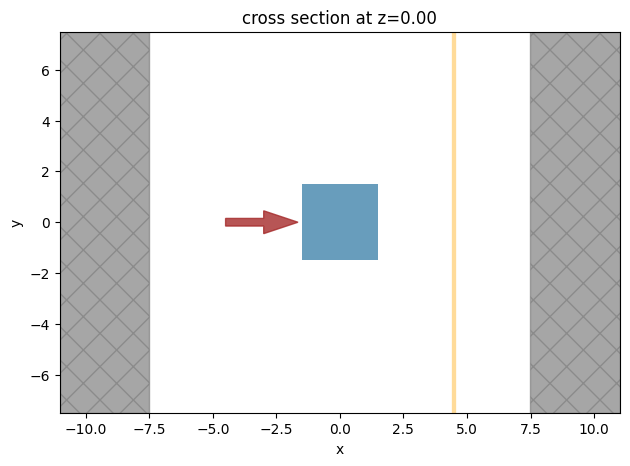

In [5]:
jax_sim = make_sim(permittivity=permittivity_val, freq=freq_min)
ax = jax_sim.plot(z=0)

### Define Objective

Now let's define our objective function for a single simulation result.

In [6]:
def post_process(sim_data: tda.JaxSimulationData) -> float:
    """O-th order diffracted power."""
    amp = sim_data['diffraction'].amps.isel(f=0).sel(orders_x=0, orders_y=0)
    return abs(amp.values)**2

And we can put everything together to define our full objective over all frequencies using the `run_async` function.

In [7]:
def objective(permittivity: float) -> float:
    """Average of O-th order diffracted power over all frequencies."""
    sim_list = [make_sim(permittivity, freq) for freq in freqs]
    sim_data_list = tda.web.run_async(sim_list, path_dir='data')
    power = [post_process(sim_data) for sim_data in sim_data_list]
    return jnp.sum(jnp.array(power)) / len(freqs)

Let's now run this function as is to make sure it works properly for only computing the objective.

In [8]:
power_average = objective(permittivity=permittivity_val)
print(f"average power (freq) = {power_average:.2e}")

           WARNING  'BoundarySpec.y' uses default value, which is 'Periodic()' but will change to   ]8;id=235224;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=883326;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=696306;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=873773;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           WARNING  'BoundarySpec.y' uses default value, which is 'Periodic()' but will change to   ]8;id=209433;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=824630;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=13502;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=96576;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

[10:35:47] INFO     Created task '0' with task_id '5612723d-69b1-4e2d-a4a1-e8089ff38266'.             ]8;id=586155;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=523582;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#131\131]8;;\

Output()

[10:35:49] INFO     Created task '1' with task_id '6c17e8dd-fd8e-4449-8b94-ee2cbdfaadde'.             ]8;id=614104;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=9670;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#131\131]8;;\

Output()

[10:35:51] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=470026;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=740962;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#270\270]8;;\

           INFO     status = queued                                                                   ]8;id=114451;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=492046;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

Output()

           INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=864058;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=241967;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#270\270]8;;\

           INFO     status = preprocess                                                               ]8;id=255641;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=912430;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

[10:35:54] INFO     starting up solver                                                                ]8;id=975370;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=92800;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

[10:35:55] INFO     running solver                                                                    ]8;id=693831;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=876684;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#314\314]8;;\

Output()

[10:35:56] INFO     status = queued                                                                   ]8;id=31384;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=113944;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#349\349]8;;\

Output()

           INFO     status = running                                                                  ]8;id=603640;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=11411;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[10:36:01] INFO     status = postprocess                                                              ]8;id=403405;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=801588;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[10:36:04] INFO     status = success                                                                  ]8;id=807601;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=910684;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

           INFO     Billed FlexUnit cost: 0.000                                                       ]8;id=785708;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=596705;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#368\368]8;;\

           INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=556054;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=441088;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#270\270]8;;\

           INFO     status = success                                                                  ]8;id=391038;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=573726;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[10:36:05] INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=667584;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=649921;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#669\669]8;;\
                    "data/5612723d-69b1-4e2d-a4a1-e8089ff38266.hdf5"                                               

Output()

[10:36:06] INFO     loading SimulationData from data/5612723d-69b1-4e2d-a4a1-e8089ff38266.hdf5        ]8;id=539958;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=143453;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#486\486]8;;\

           WARNING  Simulation final field decay value of 0.00291 is greater than the simulation      ]8;id=214325;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=978139;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#493\493]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

           INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=56127;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=856575;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#669\669]8;;\
                    "data/6c17e8dd-fd8e-4449-8b94-ee2cbdfaadde.hdf5"                                               

Output()

[10:36:07] INFO     loading SimulationData from data/6c17e8dd-fd8e-4449-8b94-ee2cbdfaadde.hdf5        ]8;id=311509;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=35765;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#486\486]8;;\

           WARNING  Simulation final field decay value of 0.014 is greater than the simulation        ]8;id=876832;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=274320;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#493\493]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

           INFO     Remote TPU is not linked into jax; skipping remote TPU.                       ]8;id=187090;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=207932;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#170\170]8;;\

           INFO     Unable to initialize backend 'tpu_driver': Could not initialize backend       ]8;id=374646;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=730211;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#421\421]8;;\
                    'tpu_driver'                                                                                   

           INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no     ]8;id=291161;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=356731;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#421\421]8;;\
                    attribute 'GpuAllocatorConfig'                                                                 

           INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no     ]8;id=680730;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=854507;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#421\421]8;;\
                    attribute 'GpuAllocatorConfig'                                                                 

           INFO     Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no      ]8;id=890170;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=876088;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#421\421]8;;\
                    attribute 'get_tpu_client'                                                                     

           INFO     Unable to initialize backend 'plugin': xla_extension has no attributes named  ]8;id=233805;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=503079;file:///Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py#421\421]8;;\
                    get_plugin_device_client. Compile TensorFlow with                                              
                    //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults                    
                    to false) to enable this.                                                                      

average power (freq) = 1.88e-03


### Multi-Frequency Gradient Calculation

Finally, we are ready to use `jax.grad` to differentiate this function.

In [9]:
grad_objective = jax.grad(objective)

grad_power_average = grad_objective(permittivity_val)
print(f"derivative of average power wrt permittivity = {grad_power_average:.2e}")

[10:36:08] WARNING  'BoundarySpec.y' uses default value, which is 'Periodic()' but will change to   ]8;id=324760;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=13815;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=958459;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=790903;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           WARNING  'BoundarySpec.y' uses default value, which is 'Periodic()' but will change to   ]8;id=974248;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=550223;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=596300;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=624374;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           INFO     Created task '0_fwd' with task_id '1fb75ea1-7f04-4329-9b67-37d3df451aab'.         ]8;id=316425;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=916056;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#131\131]8;;\

Output()

[10:36:10] INFO     Created task '1_fwd' with task_id 'e16669a0-ab88-4c4c-84fc-19e9651e0506'.         ]8;id=76554;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=398439;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#131\131]8;;\

Output()

[10:36:12] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=243770;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=308269;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#270\270]8;;\

           INFO     status = queued                                                                   ]8;id=854505;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=562870;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

Output()

           INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=636624;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=841462;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#270\270]8;;\

[10:36:13] INFO     status = preprocess                                                               ]8;id=485186;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=177083;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

[10:36:17] INFO     starting up solver                                                                ]8;id=96093;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=115785;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

[10:36:18] INFO     running solver                                                                    ]8;id=580423;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=871856;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#314\314]8;;\

Output()

           INFO     status = queued                                                                   ]8;id=575509;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=585750;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#349\349]8;;\

Output()

[10:36:19] INFO     status = running                                                                  ]8;id=251471;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=440699;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[10:36:23] INFO     status = postprocess                                                              ]8;id=538001;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=837679;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[10:36:27] INFO     status = success                                                                  ]8;id=224593;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=227442;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

           INFO     Billed FlexUnit cost: 0.000                                                       ]8;id=102329;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=183509;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#368\368]8;;\

[10:36:28] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=23867;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=961438;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#270\270]8;;\

           INFO     status = success                                                                  ]8;id=147918;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=713696;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=63232;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=56078;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#669\669]8;;\
                    "data/1fb75ea1-7f04-4329-9b67-37d3df451aab.hdf5"                                               

Output()

[10:36:29] INFO     loading SimulationData from data/1fb75ea1-7f04-4329-9b67-37d3df451aab.hdf5        ]8;id=934615;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=663530;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#486\486]8;;\

[10:36:30] WARNING  Simulation final field decay value of 0.00291 is greater than the simulation      ]8;id=643313;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=819386;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#493\493]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

           INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=444931;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=288718;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#669\669]8;;\
                    "data/e16669a0-ab88-4c4c-84fc-19e9651e0506.hdf5"                                               

Output()

[10:36:32] INFO     loading SimulationData from data/e16669a0-ab88-4c4c-84fc-19e9651e0506.hdf5        ]8;id=992050;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=22494;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#486\486]8;;\

           WARNING  Simulation final field decay value of 0.014 is greater than the simulation        ]8;id=225832;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=93524;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#493\493]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

[10:36:33] INFO     Created task '0_adj' with task_id '667fb187-e8fe-4288-b48c-d39762226848'.         ]8;id=411088;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=742021;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#131\131]8;;\

Output()

[10:36:35] INFO     Created task '1_adj' with task_id 'db730090-a144-4a44-a404-d5305b58500d'.         ]8;id=533878;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=347937;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#131\131]8;;\

Output()

[10:36:36] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=380987;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=616270;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#270\270]8;;\

           INFO     status = queued                                                                   ]8;id=469556;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=32190;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

Output()

           INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=957182;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=662789;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#270\270]8;;\

[10:36:39] INFO     status = preprocess                                                               ]8;id=654030;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=701333;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

[10:36:43] INFO     starting up solver                                                                ]8;id=822371;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=847684;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

           INFO     running solver                                                                    ]8;id=512254;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=996960;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#314\314]8;;\

Output()

[10:36:44] INFO     status = queued                                                                   ]8;id=771035;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=459130;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#349\349]8;;\

Output()

           INFO     status = running                                                                  ]8;id=734073;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=904071;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[10:36:48] INFO     status = postprocess                                                              ]8;id=868471;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=226762;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[10:36:52] INFO     status = success                                                                  ]8;id=316704;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=869867;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

           INFO     Billed FlexUnit cost: 0.000                                                       ]8;id=399991;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=348843;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#368\368]8;;\

[10:36:53] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=294047;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=405549;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#270\270]8;;\

           INFO     status = success                                                                  ]8;id=270286;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=491947;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=804805;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=344407;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#669\669]8;;\
                    "data/667fb187-e8fe-4288-b48c-d39762226848.hdf5"                                               

Output()

[10:36:54] INFO     loading SimulationData from data/667fb187-e8fe-4288-b48c-d39762226848.hdf5        ]8;id=991745;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=678894;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#486\486]8;;\

           WARNING  Simulation final field decay value of 9.66e-05 is greater than the simulation     ]8;id=65918;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=344700;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#493\493]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

[10:36:55] INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=299181;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=401391;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#669\669]8;;\
                    "data/db730090-a144-4a44-a404-d5305b58500d.hdf5"                                               

Output()

[10:36:57] INFO     loading SimulationData from data/db730090-a144-4a44-a404-d5305b58500d.hdf5        ]8;id=136756;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=482879;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#486\486]8;;\

           WARNING  Simulation final field decay value of 0.00036 is greater than the simulation      ]8;id=496706;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=193795;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#493\493]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

derivative of average power wrt permittivity = -6.58e-04


### Sanity Checking: Manual Loop over Frequency

Now we will implement the brute force approach to computing the multi-frequency gradient through looping over frequency and adding the individual gradient contributions.

In [10]:
def grad_manual(permittivity: float) -> float:
    """Average of O-th order diffracted power over all frequencies."""
    
    def objective(permittivity, freq):
        sim = make_sim(permittivity, freq)
        sim_data = tda.web.run(sim, task_name=f"f={freq:.2e}", verbose=False)
        return jnp.sum(post_process(sim_data))
    
    total_grad = 0.0
    for freq in freqs:
        print(f'working on freq = {freq:.2e} (Hz)')
        obj_fn = lambda x: objective(x, freq=freq)
        grad_fn = jax.grad(obj_fn)
        gradient = grad_fn(permittivity)
        total_grad += gradient
        
    return total_grad / len(freqs)

In [11]:
grad_man = grad_manual(permittivity_val)

working on freq = 1.00e+14 (Hz)


           WARNING  'BoundarySpec.y' uses default value, which is 'Periodic()' but will change to   ]8;id=99067;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=601667;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=406071;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=659910;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

[10:37:14] WARNING  Simulation final field decay value of 0.00291 is greater than the simulation      ]8;id=832726;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=255732;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#493\493]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

[10:37:32] WARNING  Simulation final field decay value of 9.66e-05 is greater than the simulation     ]8;id=224658;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=990520;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#493\493]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

working on freq = 2.00e+14 (Hz)


           WARNING  'BoundarySpec.y' uses default value, which is 'Periodic()' but will change to   ]8;id=819025;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=336667;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=609496;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=338883;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#607\607]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

[10:37:51] WARNING  Simulation final field decay value of 0.014 is greater than the simulation        ]8;id=674900;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=49005;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#493\493]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

[10:38:12] WARNING  Simulation final field decay value of 0.00036 is greater than the simulation      ]8;id=871733;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=18682;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#493\493]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

Finally, we can ensure that they match.

In [12]:
print(f"gradient (batched) = {grad_power_average:.4e}")
print(f"gradient (looped) = {grad_man:.4e}")

gradient (batched) = -6.5814e-04
gradient (looped) = -6.5814e-04


## Takeaways

The main thing to note here is that, using `plugins.adjoint.web.async_run`, all of the individual simulations were uploaded at roughly the same time.

This means that the server is able to work on them concurrently rather than needing to wait for the previously uploaded one to finish. The time savings for applications with several simulations can be enormous.

While we focused this example on a multi-frequency objective, this basic strategy can be broadly applied to other multi-objective problems. 

For example, if the objective depends on the results from slightly different simulations, for example dilated or contracted structures, random variation, or other instances, this general approach can be very useful.